# 1. Import libraries

In [63]:
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import random

# 2. EDA

## 2.1 Data Overview

In [106]:
# Check out what is in train.csv
train_df = pd.read_csv("../data/global-wheat-detection/train.csv")
print(f"train.csv shape {train_df.shape}\n")
print(f"train.csv dtypes {train_df.dtypes}\n")
train_df.head()

train.csv shape (147793, 5)

train.csv dtypes image_id    object
width        int64
height       int64
bbox        object
source      object
dtype: object



,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
# Look at unique values in each column
for col in train_df.columns.to_list():
    display(train_df[col].value_counts())

image_id
35b935b6c    116
f1794c924    108
f79336a8e    104
134d4a01c    101
4cf91995d     97
            ... 
86296fc32      1
ce4124be0      1
4e6c05213      1
a5cb30c38      1
41457a646      1
Name: count, Length: 3373, dtype: int64

width
1024    147793
Name: count, dtype: int64

height
1024    147793
Name: count, dtype: int64

bbox
[972, 0, 52, 84]              2
[0.0, 957.0, 79.0, 66.0]      2
[372.0, 856.0, 66.0, 64.0]    2
[302.0, 815.0, 64.0, 75.0]    2
[0.0, 385.0, 56.0, 46.0]      2
                             ..
[0, 750, 39, 78]              1
[121, 931, 119, 77]           1
[279, 965, 91, 59]            1
[588, 953, 81, 71]            1
[875.0, 740.0, 94.0, 61.0]    1
Name: count, Length: 147761, dtype: int64

source
ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: count, dtype: int64

```Observations```

1. 3373 images, all 1024 x 1024 px
2. Probably can disregard source
3. I will need to draw the bounding boxes into each image id

In [5]:
# Check number of images in train and test folder
train_dir = "../data/global-wheat-detection/train"
test_dir = "../data/global-wheat-detection/test"

train_img = [image for image in Path(train_dir).iterdir()]
train_img_ext_count = Counter([image.suffix for image in train_img])
print(f"Images in train folder: {len(train_img)}")
print(f"Image suffixes: {train_img_ext_count}")

print()

test_img = [image for image in Path(test_dir).iterdir()]
test_img_ext_count = Counter([image.suffix for image in test_img])
print(f"Images in test folder: {len(test_img)}")
print(f"Image suffixes: {test_img_ext_count}")

print(dir(train_img))

Images in train folder: 3422
Image suffixes: Counter({'.jpg': 3422})

Images in test folder: 10
Image suffixes: Counter({'.jpg': 10})
['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


```Observations```

1. There are 3422 images in train folder, but only 3733 unique IDs in train.csv.
    - Explore further to see which unique IDs do not have images in train folder
2. All .jpg extension in train folder. Great

In [6]:
# Investigate missing IDs in train.csv
## Check which images in train folder is not present in unique ID in train.csv
train_img_name = [image.stem for image in train_img]
train_csv_id = train_df["image_id"].unique()

print(f"No. of unique train image names: {len(set(train_img_name))}")
print(f"No. of unique image_ids: {len(set(train_csv_id))}")

missing_id = set(train_img_name) - set(train_csv_id)
print(f"No. of train images with no image IDs: {len(missing_id)}")
print(missing_id)


No. of unique train image names: 3422
No. of unique image_ids: 3373
No. of train images with no image IDs: 49
{'155c440e8', '7e1caf1f7', '1a9792bfc', 'c74ca81bd', '00b5c6764', 'd771bb084', '0cf7ef43d', 'ab20ec355', '5cbd092f9', 'f9cafa47f', 'f2a6804d2', 'e01ad95cf', '46c6a747a', 'ffbb9c623', '5901a73fe', '952e7d15c', '526d737d1', '8425a537b', '39a0e5556', '581eaf87b', 'ed00a614d', '2e6c333a7', 'c18c32da0', '69352f3fa', '0e7832f0b', 'ccb3892c1', 'cfc9040ca', '8a5cb62db', 'b45c5294d', '2d80f9c49', 'ec196d18a', 'a3ce975cd', '65d0b13aa', '49e40c7a4', 'de2a3cf37', 'f530a5d4b', '9e21e7969', 'dd5d2fa9e', 'dec23c826', '6584c18c0', 'cf1d2f504', '91d4e3750', '8de789df8', 'e4ec17f9b', 'd7e657453', '3116768f0', 'd83808467', '83a94fc79', '45fddc611'}


```Observations```

1. Found the 49 train images with no image IDs
2. Most probably will have to drop them because there is no BB
3. Draw my own BB?

Text(0.5, 1.0, 'Frequency distribution of bounding boxes')

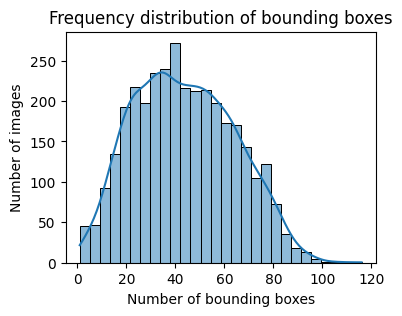

In [ ]:
# Check each image has how many bounding boxes
bbox_count = train_df.groupby("image_id")["bbox"].size().sort_values(ascending=False)

# Visualize with a histplot
plt.figure(figsize=(4, 3))
sns.histplot(data=bbox_count, kde=True)
plt.xlabel("Number of bounding boxes")
plt.ylabel("Number of images")
plt.title("Frequency distribution of bounding boxes")

In [53]:
# Check modes for all images in train folder
modes = []
for img in train_img:
    with Image.open(img) as img:
        mode = img.mode
        modes.append(mode)
train_img_modes = Counter(modes)
print(train_img_modes)

Counter({'RGB': 3422})


## 2.2 Color Analysis


In [71]:
train_csv_id

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], shape=(3373,), dtype=object)

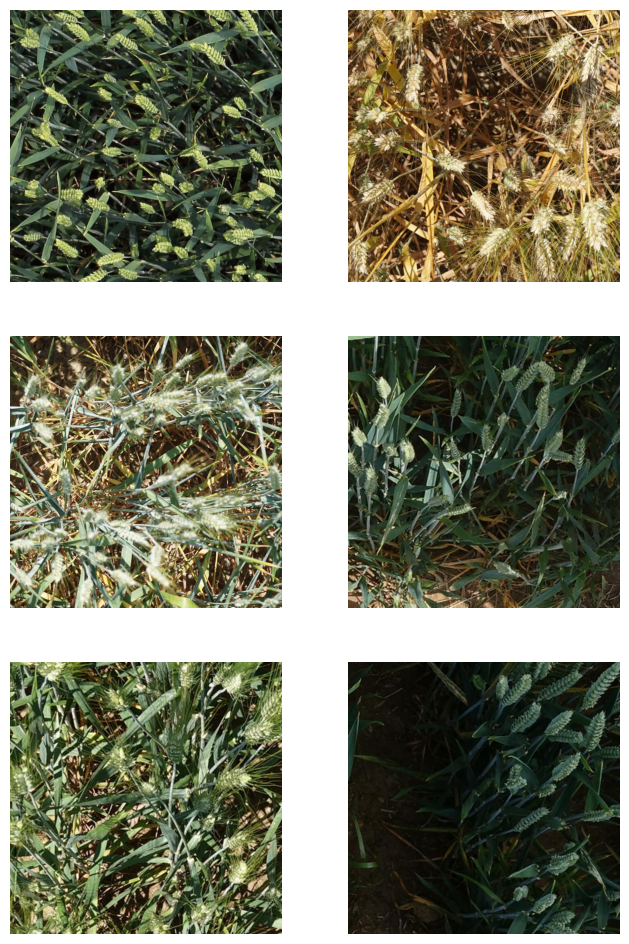

In [ ]:
# Visual check on random train images
num_samples = 6
random_idx = random.sample(range(train_csv_id.shape[0]), num_samples)

# Get list of file path for me to iterate an open
img_paths = [f"{train_dir}/{train_csv_id[idx]}.jpg" for idx in random_idx]

# Visualize random images
fig, axes = plt.subplots(3, 2, figsize=(8, 12))

for ax, image_path in zip(axes.flat, img_paths):
    img = Image.open(image_path)
    ax.imshow(img)
    ax.axis("off")

plt.show()

```Observations```

1. Observed picture quality issues
- Pictures too dark/bright (no sunlight or too much sunlight)
- Wheathead too small / not many / none
- Low contrast, blurry (grass and wheathead mixed/same color)
- Some look like might not have weed at all
2. Draw boundary boxes and visualize image data

In [108]:
# Look at drawing boundary boxes on the image data
# Note bbox is formated as object/string in format [xmin, ymin, width, height]
print(f"bbox example:{train_df['bbox'].iloc[0]}")

bbox example:[834.0, 222.0, 56.0, 36.0]
